# MSAI 495: Deep Reinforcement Learning
### Final Project
### Tianhao Lei, Peter Salvino, Ruize Yang, & Qiaohan Yang

Package requirements:
-datajoint (Requires Python>= 3.4)
-if data is download, please load data with pickle

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import pickle as pk
import matplotlib.pyplot as plt
import ssm
from ssm.util import find_permutation

## Run the following parts if you need to clean the data.
### If not, please download the clean data and skip this part

In [2]:
# load the raw data
data_path=r'data/behaviordata'

with open(data_path,'rb') as f:
    data=pk.load(f)
data[['subject_fullname','session_number','trial_id','trial_type','choice']]

,subject_fullname,session_number,trial_id,trial_type,choice
0,apr456_CR1,1,1,R,L
1,apr456_CR1,1,2,L,L
2,apr456_CR1,1,3,R,L
3,apr456_CR1,1,4,L,L
4,apr456_CR1,1,5,L,L
...,...,...,...,...,...
416783,Unknown_Peter,1,1,R,R
416784,Unknown_Peter,1,2,R,R
416785,Unknown_Peter,1,3,L,L
416786,Unknown_Peter,1,4,L,L


In [3]:
# remove test mice
data = data[~(data.subject_fullname.isin(["Unknown_Peter", "apr456_CR6error", "lpr6177_test1", "pss3570_TrainTest"]))]

# only keep session with final maze
data = data[data.main_maze_id == 11]

# remove trials in warmup block
data = data[data.maze_id == 11]

# re-index
data.reset_index(drop=True, inplace = True)

data

,subject_fullname,session_date,session_number,task,protocol_id,trial_id,maze_id,main_maze_id,trial_type,choice,...,t_cue_entry,t_mem_entry,t_turn,t_choice_made,t_reward,t_iti,trial_prior_p_right,reward_amount,block_performance,is_first_trial_of_block
0,apr456_CR1,2021-09-28,2,TowersTaskSwitch,2,17,11,11,R,R,...,1.20552,3.99751,4.29751,7.14768,7.15610,8.44789,NaN,1.8,1.000000,1
1,apr456_CR1,2021-09-28,2,TowersTaskSwitch,2,18,11,11,L,L,...,1.25294,3.86986,3.90327,6.67835,6.68664,7.98687,NaN,1.8,1.000000,0
2,apr456_CR1,2021-09-28,2,TowersTaskSwitch,2,19,11,11,L,L,...,1.28354,3.70875,3.70875,7.17565,7.18403,8.46765,NaN,1.8,1.000000,0
3,apr456_CR1,2021-09-28,2,TowersTaskSwitch,2,20,11,11,R,R,...,1.23340,3.95028,3.96694,7.61773,7.63231,8.92588,NaN,1.8,1.000000,0
4,apr456_CR1,2021-09-28,2,TowersTaskSwitch,2,21,11,11,L,L,...,1.62524,4.23376,4.23376,7.22577,7.23439,8.52593,NaN,1.8,1.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134369,apr456_TS8,2021-11-09,1,TowersTaskSwitchEasy,3,209,11,11,R,R,...,6.02491,9.70000,9.70833,12.88370,12.89230,14.50070,NaN,3.0,0.333333,0
134370,apr456_TS8,2021-11-09,1,TowersTaskSwitchEasy,3,210,11,11,L,R,...,2.63380,5.45876,6.50895,8.57607,NaN,9.64249,NaN,0.0,0.333333,0
134371,apr456_TS8,2021-11-09,1,TowersTaskSwitchEasy,3,211,11,11,R,R,...,3.08150,5.95687,8.80719,9.73256,9.74058,11.34070,NaN,3.0,0.333333,0
134372,apr456_TS8,2021-11-09,1,TowersTaskSwitchEasy,3,218,11,11,R,R,...,1.11419,3.38098,5.69792,7.87327,7.88175,9.49006,NaN,3.0,1.000000,1


In [4]:
# find sessions with more than 200 trial
session = data.groupby(["subject_fullname", "session_date", "session_number"]).size().reset_index().rename(columns={0:'trial_count'})
session_large = session[session.trial_count > 200]
session_large = session_large.drop('trial_count', 1)

# keep only data in good sessions
data = pd.merge(data, session_large, how='outer', indicator=True)
data = data[data._merge == "both"]

data = data.drop('_merge', 1)
data.reset_index(drop=True, inplace = True)


/var/folders/4x/y92l2fhs0vgdynj3nfnsq6k00000gn/T/ipykernel_82794/1954714835.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  session_large = session_large.drop('trial_count', 1)
/var/folders/4x/y92l2fhs0vgdynj3nfnsq6k00000gn/T/ipykernel_82794/1954714835.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data = data.drop('_merge', 1)


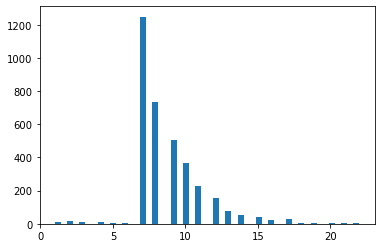

/var/folders/4x/y92l2fhs0vgdynj3nfnsq6k00000gn/T/ipykernel_82794/1869163912.py:16: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data = data.drop('block_keep', 1)


In [5]:
# find the start and length of each block
block_start = data[data.is_first_trial_of_block == 1]
block_start = block_start.index.to_numpy()
block_start = np.append(block_start, len(data))
block_length = np.diff(block_start)

plt.hist(np.sort(block_length)[0:-2], bins = 50)
plt.show()

# keep only blocks with length > 10
block_keep = 1 * (block_length >= 10)
block_keep = np.repeat(block_keep, block_length)
data['block_keep'] = block_keep
data = data[data.block_keep == 1]

data = data.drop('block_keep', 1)
data.reset_index(drop=True, inplace = True)


In [6]:
test = data.groupby(["subject_fullname", "session_date", "session_number"]).size().reset_index().rename(columns={0:'trial_count'})
print(test.to_string())

    subject_fullname session_date  session_number  trial_count
0         apr456_CR2   2021-10-12               1          115
1         apr456_CR3   2021-11-03               1           80
2         apr456_CR3   2021-11-05               1          115
3         apr456_CR3   2021-11-09               1           69
4         apr456_CR3   2021-11-09               2           60
5         apr456_CR3   2021-11-23               1           58
6         apr456_CR3   2022-02-28               1           98
7         apr456_CR3   2022-03-11               1           66
8         apr456_CR3   2022-03-18               2          110
9         apr456_CR4   2021-11-09               1          112
10        apr456_CR4   2021-11-23               1           68
11        apr456_CR4   2022-02-21               1           93
12        apr456_CR4   2022-03-08               1          102
13        apr456_CR4   2022-03-21               1           51
14        apr456_CR5   2022-03-08               1      

In [7]:
# add previous trial response and previous stim
previous_choice=data['choice'].to_numpy()
previous_choice=np.insert(previous_choice,0,'nil')
previous_choice=np.delete(previous_choice,-1)
data['previous_choice']=previous_choice
previous_stim = data['num_towers_delta'].to_numpy()
previous_stim = np.insert(previous_stim, 0, 'nil')
previous_stim = np.delete(previous_stim, -1)
data['previous_stim'] = previous_stim

# remove nil, 1st trial of block
data = data.drop(data[data.choice == 'nil'].index)
data = data.drop(data[data.previous_choice == 'nil'].index)
data = data.drop(data[data.is_first_trial_of_block == 1].index)

In [9]:
# save the data
save_path=r'data/behaviordata_clean.csv'
data.to_csv(save_path)

## Load clean data

In [8]:
clean_data_path=r'data/behaviordata_clean.csv'
data=pd.read_csv(clean_data_path)

### Initialize GLM-HMM

-- The number of states is a selected based on the Ashwood et al. (2020) paper in which they discovered three internal state of mice.
-- observation dimension is just the choice the mouse made after reach to the end of the maze of each trial, which is one dimensional
-- number of categories is the number of noices the mouse can make. In this case, it is either left (1) or right (0)
-- input dimension includes 4 types of input: (1) stimulus of previous trial, (2) stimulus of current trial, (3) choice of last trial and (4) a constant bias term

In [9]:
# Set the paramters of the GLM-HMM
num_states = 3        # number of discrete states
obs_dim = 1           # number of observed dimensions
num_categories = 2    # number of categories for output
input_dim = 4         # input dimensions
# bias + previous stim +previous choice +  stim

# Make a GLM-HMM
true_glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs",
                   observation_kwargs=dict(C=num_categories), transitions="standard")

In [11]:
# formatting the data type for true choice and model inputs

true_choice=data['choice'].to_numpy()
true_choice[np.where(true_choice=='L')]=1
true_choice[np.where(true_choice=='R')]=0
# format for true choice:
# a list of sessions. Each session(i) is an ndarray with data type of int and shape of trial_len(i) x 1
true_choice=[true_choice[:,np.newaxis].astype(int)]

# format for inpts:
# a list of sessions, same length of true choice.
# Each session(i) is an ndarray with data type of float and shape of trial_len(i) x input_dim
inpts=data[['previous_choice','previous_stim','num_towers_delta']].to_numpy()
inpts=np.hstack([inpts,np.random.rand(len(inpts),1)])
inpts[np.where(inpts=='L')]=1
inpts[np.where(inpts=='R')]=0
inpts=[inpts.astype(float)]

# # divide data into training and testing
inpts = np.array(inpts)
numtest = np.floor(inpts.shape[1]*0.1).astype(int)
train_idx = np.ones(inpts.shape[1]).astype(bool)
train_idx[:numtest] = False
test_idx = ~train_idx
inpts_train = inpts[:, train_idx, :]
inpts_test = inpts[:, test_idx, :]

inpts_train = list(inpts_train)
inpts_test = list(inpts_test)
true_choice_train = [true_choice[0][train_idx]]
true_choice_test = [true_choice[0][test_idx]]
inpts = list(inpts)

print(inpts_train[0].shape)
print(true_choice_train[0].shape)

(9659, 4)
(9659, 1)


### Model fitting
Here we use the training set to fit the model

In [13]:
print(true_choice_train[0].shape)
print(inpts_train[0].shape)
N_iter=500
fit_ll=true_glmhmm.fit(true_choice_train,inputs=inpts_train,method='em',num_iters=N_iter,tolerance=10e-8)

(9659, 1)
(9659, 4)


  0%|          | 0/500 [00:00<?, ?it/s]

In [21]:
# calculate negative log likelihood for training set and testing set
train_set_ll = true_glmhmm.log_probability(true_choice_train, inputs=inpts_train)
test_set_ll = true_glmhmm.log_probability(true_choice_test, inputs=inpts_test)
print("training set standardized log likelihood = " + str(train_set_ll/len(true_choice_train[0])))
print("testing set standardized log likelihood = " + str(test_set_ll/len(true_choice_test[0])))

training set standardized log likelihood = -0.6032582331642011
testing set standardized log likelihood = -0.6523987259124749


Here we can see LL on training set is larger than LL on testing set

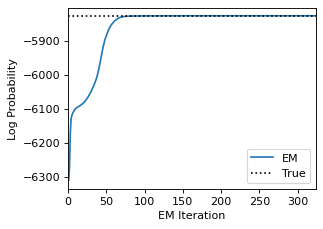

In [22]:
# Plot the log probabilities of the true and fit models. Fit model final NLL should be greater
# than or equal to true LL.
fig = plt.figure(figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
plt.plot(fit_ll, label="EM")
plt.plot([0, len(fit_ll)], train_set_ll * np.ones(2), ':k', label="True")
plt.legend(loc="lower right")
plt.xlabel("EM Iteration")
plt.xlim(0, len(fit_ll))
plt.ylabel("Log Probability")
plt.show()

## Retrieved parameters
Take a peak into the transition probability of the trained model. And further look into the state transition over time

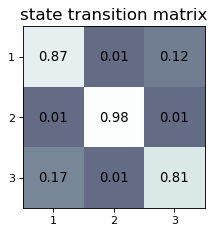

In [23]:
fig = plt.figure(figsize=(5, 2.5), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 2)
recovered_trans_mat = np.exp(true_glmhmm.transitions.log_Ps)
plt.imshow(recovered_trans_mat, vmin=-0.8, vmax=1, cmap='bone')
for i in range(recovered_trans_mat.shape[0]):
    for j in range(recovered_trans_mat.shape[1]):
        text = plt.text(j, i, str(np.around(recovered_trans_mat[i, j], decimals=2)), ha="center", va="center",
                        color="k", fontsize=12)
plt.xlim(-0.5, num_states - 0.5)
plt.xticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.yticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.ylim(num_states - 0.5, -0.5)
plt.title("state transition matrix", fontsize = 15)
plt.subplots_adjust(0, 0, 1, 1)

In [35]:
# Get expected states:
posterior_probs = [true_glmhmm.expected_states(data=data, input=inpt)[0]
                for data, inpt
                in zip(true_choice, inpts)]

Text(0, 0.5, 'p(state)')

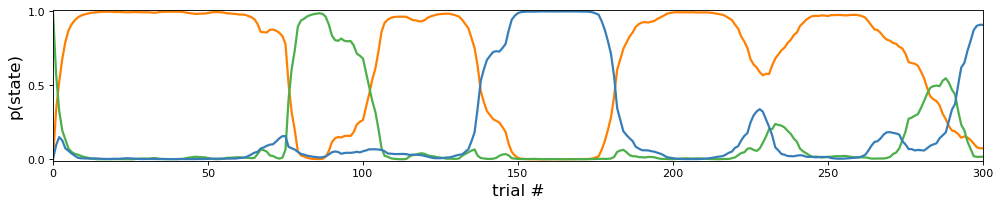

In [36]:
fig = plt.figure(figsize=(15, 2.5), dpi=80, facecolor='w', edgecolor='k')
cols = ['#ff7f00', '#4daf4a', '#377eb8']
sess_id = 0 #session id; can choose any index between 0 and num_sess-1
for k in range(num_states):
    plt.plot(posterior_probs[sess_id][:, k], label="State " + str(k + 1), lw=2,
             color=cols[k])
plt.ylim((-0.01, 1.01))
plt.xlim((0, 300))
plt.yticks([0, 0.5, 1], fontsize = 10)
plt.xlabel("trial #", fontsize = 15)
plt.ylabel("p(state)", fontsize = 15)

In [27]:
# simulate the result based on test inputs

simulated_z,simulated_x=true_glmhmm.sample(len(inpts_train[0]),input=inpts_train[0]) # simulated_x is the simulated data
correct=np.where(simulated_x-true_choice_train[0]==0)[0]
correctness=len(correct)/len(true_choice_train[0])

p=len(np.where(true_choice_train[0]==0)[0])/len(true_choice_train[0])
print(f'frequency of choice R in true_choice_test: {p}')
print(f'correct choice of choosing R :{correctness}')

frequency of choice R in true_choice_test: 0.5147530800289886
correct choice of choosing R :0.5467439693550057
